## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb 

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice. 
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 

C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space'] 

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [3]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

In [4]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

In [ ]:
model_args = ClassificationArgs()
model_args.overwrite_output_dir=True 
model_args.evaluate_during_training=True 
model_args.num_train_epochs=10 
model_args.train_batch_size=32
model_args.learning_rate=5e-6
model_args.max_seq_length=128
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 

In [6]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 64 steps.


In [ ]:
model = ClassificationModel(
    model_type="xlnet",       
    model_name="xlnet-base-cased",   
    num_labels=4,               
    args=model_args,
    use_cuda=True
)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
_, history = model.train_model(train, eval_df=dev) 

5it [00:12,  2.55s/it]                       
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\simpletransformers\classification\classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 10:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\simpletransformers\classification\classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\

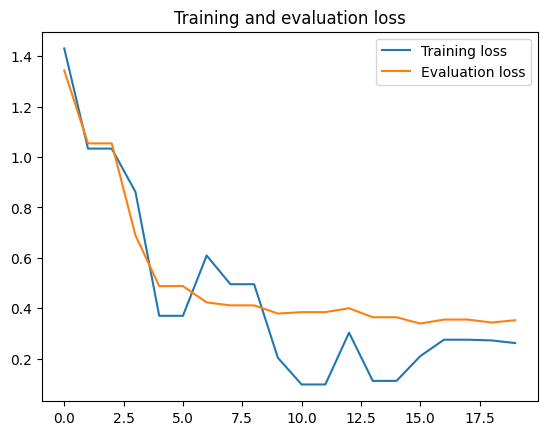

In [ ]:
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

1it [00:06,  6.59s/it]
Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\simpletransformers\classification\classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Running Evaluation: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


{'mcc': np.float64(0.8358674042551543), 'eval_loss': 0.3517921368281047}

In [11]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

3it [00:08,  2.92s/it]                       
  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\simpletransformers\classification\classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


In [12]:
test.head(5)

,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,1
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,2
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2


In [ ]:
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       319
           1       0.89      0.92      0.90       389
           2       0.86      0.90      0.88       396
           3       0.88      0.79      0.83       394

    accuracy                           0.86      1498
   macro avg       0.86      0.86      0.86      1498
weighted avg       0.86      0.86      0.86      1498



In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)


train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})
train, dev = train_test_split(train, test_size=0.1, random_state=42, stratify=train['labels'])


vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['text'])
X_dev = vectorizer.transform(dev['text'])
X_test = vectorizer.transform(test['text'])
y_train = train['labels']
y_dev = dev['labels']
y_test = test['labels']


nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_dev_pred = nb_classifier.predict(X_dev)
print("Development Set Classification Report:")
print(classification_report(y_dev, y_dev_pred))
y_test_pred = nb_classifier.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Development Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.89        48
           1       0.93      0.88      0.90        59
           2       0.80      0.95      0.87        60
           3       0.88      0.88      0.88        59

    accuracy                           0.88       226
   macro avg       0.90      0.88      0.89       226
weighted avg       0.89      0.88      0.89       226

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       319
           1       0.90      0.86      0.88       389
           2       0.74      0.92      0.82       396
           3       0.83      0.82      0.82       394

    accuracy                           0.83      1498
   macro avg       0.84      0.82      0.82      1498
weighted avg       0.84      0.83      0.83      1498

